In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
tf.compat.v1.experimental.output_all_intermediates(True)

In [2]:
tf.random.set_seed(36)

In [3]:
BASE_DIR_PATH = '../../Datasets'
DATASET_FILE = os.path.join(BASE_DIR_PATH, 'compiled_data_2016_2017.csv')

In [4]:
df = pd.read_csv(DATASET_FILE)
df

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,16059,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 19:00:00,63140400.0,14420
17516,17516,16424,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 20:00:00,63144000.0,14420
17517,17517,16789,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 21:00:00,63147600.0,14420
17518,17518,17154,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 22:00:00,63151200.0,14420


In [5]:
df = df[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'Waterlevel_Sto_Nino']]
df.head(10)

,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino
0,0,1,2,0,0,12.18
1,0,1,1,1,0,12.19
2,1,1,1,0,1,12.19
3,0,0,0,1,0,12.20
4,1,1,1,0,0,12.20
5,0,0,1,0,0,12.20
6,0,1,1,0,0,12.21
7,0,0,0,0,0,12.21
8,1,0,1,0,0,12.21
9,0,0,0,0,0,12.21


In [6]:
# Splitting for time series: split into 50-25-25
n = len(df)
train_df = df[0:int(n*0.5)]
val_df = df[int(n*0.5):int(n*0.75)]
test_df = df[int(n*0.75):]

In [7]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data, shuffle=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [8]:
window = WindowGenerator(
        input_width=6, label_width=1, shift=1,
        label_columns=['Waterlevel_Sto_Nino']
    )

window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel_Sto_Nino']

In [9]:
for example_inputs, example_labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [10]:
window.example

(<tf.Tensor: shape=(32, 6, 6), dtype=float32, numpy=
 array([[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 12.59],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 12.59],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 12.58],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 12.58],
         [ 1.  ,  0.  ,  0.  ,  0.  ,  0.  , 12.58],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 12.57]],
 
        [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 11.9 ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 11.9 ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 11.9 ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 11.9 ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 11.9 ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 11.9 ]],
 
        [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 13.39],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 13.4 ],
         [ 7.  ,  0.  ,  0.  ,  2.  ,  4.  , 13.46],
         [ 2.  , 10.  ,  5.  ,  1.  ,  1.  , 13.45],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , 13.47],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0

## Metrics

In [11]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [12]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Training Loop

In [13]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

## Models

In [14]:
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1,-1])
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(6,), activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

## Training

In [15]:
dense_history = compile_and_fit(dense, window)

Epoch 1/20
274/274 [==============================] - 6s 12ms/step - loss: 3.2882 - mean_squared_error: 3.2882 - NSE: -6.7374 - r_square: 0.6802 - val_loss: 0.0692 - val_mean_squared_error: 0.0692 - val_NSE: 0.0059 - val_r_square: 0.6691
Epoch 2/20
274/274 [==============================] - 3s 10ms/step - loss: 0.0697 - mean_squared_error: 0.0697 - NSE: 0.8262 - r_square: 0.8851 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_NSE: 0.2707 - val_r_square: 0.7268
Epoch 3/20
274/274 [==============================] - 2s 9ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - NSE: 0.8778 - r_square: 0.9132 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_NSE: 0.4561 - val_r_square: 0.7539
Epoch 4/20
274/274 [==============================] - 2s 8ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - NSE: 0.9045 - r_square: 0.9316 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_NSE: 0.4436 - val_r_square: 0.7773
Epoch 5/20
274/274 [==============================] -

In [16]:
dense_history.history

{'loss': [3.2881600856781006,
  0.06966462731361389,
  0.04646735638380051,
  0.03940794989466667,
  0.03303134813904762,
  0.039190202951431274,
  0.03254517540335655,
  0.02242407016456127,
  0.025440428406000137,
  0.03117644600570202],
 'mean_squared_error': [3.2881600856781006,
  0.06966462731361389,
  0.04646735638380051,
  0.03940794989466667,
  0.03303134813904762,
  0.039190202951431274,
  0.03254517540335655,
  0.02242407016456127,
  0.025440428406000137,
  0.03117644600570202],
 'NSE': [-6.737372875213623,
  0.8262125253677368,
  0.8778225779533386,
  0.9044537544250488,
  0.9162060618400574,
  0.9029176235198975,
  0.9190429449081421,
  0.9410582184791565,
  0.9370189309120178,
  0.9173919558525085],
 'r_square': [0.6802442073822021,
  0.8851096630096436,
  0.9131625890731812,
  0.9316368699073792,
  0.9393827319145203,
  0.9336923956871033,
  0.9440024495124817,
  0.958534300327301,
  0.9558082222938538,
  0.9456372857093811],
 'val_loss': [0.06922190636396408,
  0.0472907

In [17]:
conv_history = compile_and_fit(conv_model, window)

Epoch 1/20
274/274 [==============================] - 5s 12ms/step - loss: 5.3864 - mean_squared_error: 5.3864 - NSE: -13.3973 - r_square: 0.7827 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_NSE: 0.5328 - val_r_square: 0.7948
Epoch 2/20
274/274 [==============================] - 3s 9ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - NSE: 0.9010 - r_square: 0.9340 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_NSE: 0.6982 - val_r_square: 0.8322
Epoch 3/20
274/274 [==============================] - 2s 9ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - NSE: 0.9459 - r_square: 0.9573 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_NSE: 0.7727 - val_r_square: 0.8507
Epoch 4/20
274/274 [==============================] - 3s 9ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - NSE: 0.9554 - r_square: 0.9647 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_NSE: 0.7683 - val_r_square: 0.8628
Epoch 5/20
274/274 [==============================] -

In [18]:
lstm_history = compile_and_fit(lstm_model, window)

Epoch 1/20
274/274 [==============================] - 13s 23ms/step - loss: 8.0611 - mean_squared_error: 8.0611 - NSE: -19.9218 - r_square: 0.1799 - val_loss: 0.2366 - val_mean_squared_error: 0.2366 - val_NSE: -2.9627 - val_r_square: 0.0920
Epoch 2/20
274/274 [==============================] - 5s 17ms/step - loss: 0.1894 - mean_squared_error: 0.1894 - NSE: 0.5308 - r_square: 0.6319 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_NSE: 0.5435 - val_r_square: 0.7748
Epoch 3/20
274/274 [==============================] - 5s 16ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - NSE: 0.9382 - r_square: 0.9577 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_NSE: 0.7763 - val_r_square: 0.8530
Epoch 4/20
274/274 [==============================] - 5s 17ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - NSE: 0.9519 - r_square: 0.9686 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_NSE: 0.8136 - val_r_square: 0.8708
Epoch 5/20
274/274 [============================

## Predictions

In [19]:
def get_predictions(model, test_set):
    y_pred = []
    
    for x, _ in test_set:
        predictions = model(x)
        for y in predictions:
            y_pred.append(y)
    
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    
    return y_pred

In [20]:
def plot_graph(true, pred):
    plt.plot(true, label='Observed Values')
    plt.plot(pred, label='Predicted Values', alpha=0.5)
    plt.legend()
    plt.show()

In [21]:
def calc_nse(true, pred):
    SS_res = np.sum(np.square(true-pred))
    SS_tot = np.sum(np.square(true-np.mean(true)))
    
    return 1 - SS_res/SS_tot

In [22]:
def calc_mse(true, pred):
    return np.mean(np.square(true-pred))

In [23]:
test_df

,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino
13140,0,0,0,0,0,11.89
13141,0,0,0,0,0,11.87
13142,0,0,0,0,0,11.85
13143,0,4,0,0,0,11.84
13144,11,19,0,22,0,11.84
...,...,...,...,...,...,...
17515,0,0,0,0,0,12.44
17516,0,0,0,0,0,12.44
17517,0,0,0,0,0,12.44
17518,0,0,0,0,0,12.44


In [24]:
test_vals = test_df['Waterlevel_Sto_Nino'].values
y_true = test_vals[6:]
y_true = y_true.reshape(-1)
y_true

array([12.63, 12.81, 12.8 , ..., 12.44, 12.44, 12.44])

DNN

In [25]:
dnn_pred = get_predictions(dense, window.test)
dnn_pred

array([12.895578, 11.317832, 11.841884, ..., 12.391186, 12.391186,
       12.391186], dtype=float32)

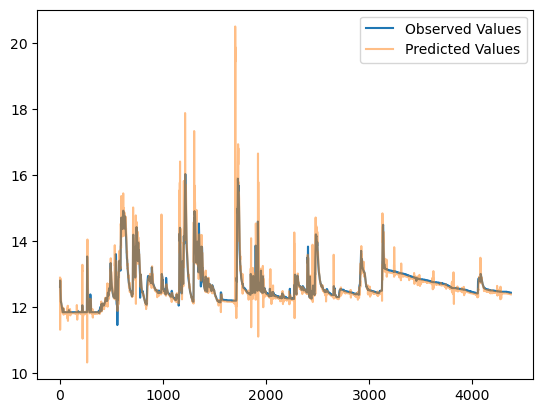

In [26]:
plot_graph(y_true, dnn_pred)

In [27]:
dnn_pred.shape

(4374,)

In [28]:
calc_nse(y_true, dnn_pred)

0.6556119281123653

In [29]:
calc_mse(y_true, dnn_pred)

0.10682188038427064

CNN

In [30]:
cnn_pred = get_predictions(conv_model, window.test)
cnn_pred

array([12.5001745, 12.598481 , 12.050708 , ..., 12.428866 , 12.428866 ,
       12.428866 ], dtype=float32)

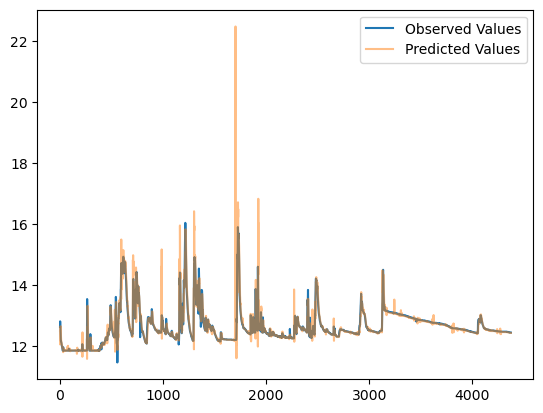

In [31]:
plot_graph(y_true, cnn_pred)

In [32]:
calc_nse(y_true, cnn_pred)

0.6198237343025388

In [33]:
calc_mse(y_true, cnn_pred)

0.11792261955147887

LSTM

In [34]:
lstm_pred = get_predictions(lstm_model, window.test)
lstm_pred

array([12.826229, 12.514668, 12.497249, ..., 12.40375 , 12.40375 ,
       12.40375 ], dtype=float32)

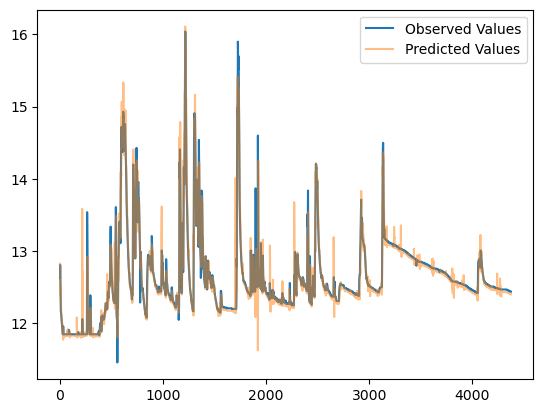

In [35]:
plot_graph(y_true, lstm_pred)

In [36]:
calc_nse(y_true, lstm_pred)

0.9187724509555573

In [37]:
calc_mse(y_true, lstm_pred)

0.025195064046132202

In [38]:
np.savetxt('../results/multivariate_dnn_predictions.csv', dnn_pred, delimiter=',', fmt='%.4f')

In [39]:
np.savetxt('../results/multivariate_cnn_predictions.csv', cnn_pred, delimiter=',', fmt='%.4f')

In [40]:
np.savetxt('../results/multivariate_lstm_predictions.csv', lstm_pred, delimiter=',', fmt='%.4f')